In [1]:
# Load dependencies
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.cuda as cutorch
import timeit
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("CUDA status: ", torch.cuda.is_available())
torch.cuda.max_memory_allocated()

PyTorch Version:  1.0.0
Torchvision Version:  0.2.1
CUDA status:  True


0

In [2]:
# Helper functions
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [3]:
# Dataloader with paths
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

# Validate on the test set

In [4]:
# Set global properties
num_classes=2
input_size=224
batch_size=8
data_dir = "/home/pyushkevich/data/twoway"

In [6]:
# Read the model
model_ft = models.resnet50(pretrained=False)
model_ft.fc = nn.Linear(model_ft.fc.in_features, num_classes)
model_ft.load_state_dict(torch.load('my_resnet_50_200epoch.dat'))

# Send model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Sending loaded model to device: ", device)
model_ft = model_ft.to(device)

Sending loaded model to device:  cuda:0


In [7]:
# Create a data loader
dt = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

ds = ImageFolderWithPaths(os.path.join(data_dir, "test"), dt)
dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=4)

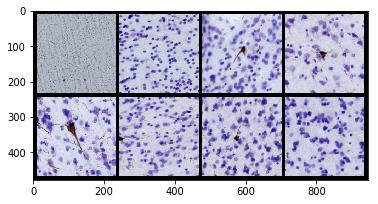

In [12]:
# Read a batch of data
img,label,paths=next(iter(dl))
show(torchvision.utils.make_grid(img, padding=10, nrow=4, normalize=True))

In [13]:
# Evaluate model on this batch
model_ft.eval()
img_d = img.to(device)
label_d = label.to(device)
outputs = model_ft(img_d)
_, preds = torch.max(outputs, 1)
(preds.cpu(),label)


(tensor([0, 0, 1, 1, 1, 1, 1, 0]), tensor([0, 0, 1, 1, 1, 0, 1, 0]))

In [41]:
# Perform full test set evaluation and save examples of errors

cm=np.zeros((num_classes,num_classes))
img_fp = torch.empty(0)
img_fn = torch.empty(0)
path_fp = []
path_fn = []
for img,label,paths in dl:
    img_d = img.to(device)
    label_d = label.to(device)
    outputs = model_ft(img_d)
    _, preds = torch.max(outputs, 1)
    for a in range(0,len(label)):
        l_pred = preds.cpu()[a].item()
        l_true = label[a].item()
        cm[l_pred,l_true]=cm[l_pred,l_true]+1
        if l_pred == 1 and l_true == 0:
            # False positive (non-tangle classified as tangle)
            img_fp = torch.cat((img_fp, img_d[a:a+1,:,:,:].cpu()))
            path_fp.append(paths[a]) 
        elif l_pred == 0 and l_true == 1:
            # False negative (tangle classified as non-tangle)
            img_fn = torch.cat((img_fn, img_d[a:a+1,:,:,:].cpu()))
            path_fn.append(paths[a]) 

cm

array([[329.,  10.],
       [ 21., 249.]])

In [42]:
(cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])

0.9490968801313628

['/home/pyushkevich/data/data/threads/660.png',
 '/home/pyushkevich/data/data/threads/1181.png',
 '/home/pyushkevich/data/data/threads/300.png',
 '/home/pyushkevich/data/data/dirt/1180.png',
 '/home/pyushkevich/data/data/threads/1740.png',
 '/home/pyushkevich/data/data/threads/1500.png',
 '/home/pyushkevich/data/data/astrocyte_tau/2780.png',
 '/home/pyushkevich/data/data/dirt/991.png',
 '/home/pyushkevich/data/data/ambiguous/540.png',
 '/home/pyushkevich/data/data/artifact/1970.png',
 '/home/pyushkevich/data/data/threads/421.png',
 '/home/pyushkevich/data/data/threads/900.png',
 '/home/pyushkevich/data/data/astrocyte_tau/2790.png',
 '/home/pyushkevich/data/data/ambiguous/2051.png',
 '/home/pyushkevich/data/data/astrocyte_tau/1761.png',
 '/home/pyushkevich/data/data/threads/231.png',
 '/home/pyushkevich/data/data/astrocyte_tau/591.png',
 '/home/pyushkevich/data/data/ambiguous/2791.png',
 '/home/pyushkevich/data/data/threads/211.png',
 '/home/pyushkevich/data/data/astrocyte_tau/2200.png'

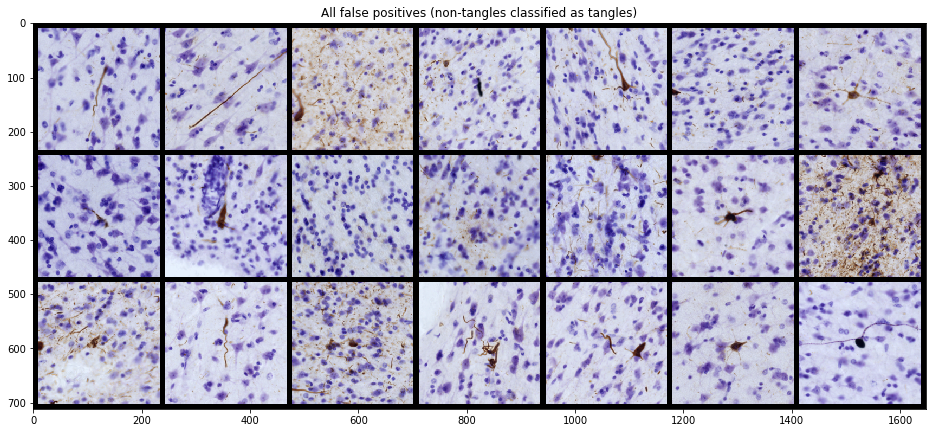

In [48]:
# Plot the false positives
plt.figure(figsize=(16,16))
show(torchvision.utils.make_grid(img_fp, padding=10, nrow=7, normalize=True))
plt.title("All false positives (non-tangles classified as tangles)");
list(map(os.path.realpath, path_fp))

['/home/pyushkevich/data/data/tangle/2681.png',
 '/home/pyushkevich/data/data/tangle/391.png',
 '/home/pyushkevich/data/data/tangle/1981.png',
 '/home/pyushkevich/data/data/tangle/2910.png',
 '/home/pyushkevich/data/data/tangle/2960.png',
 '/home/pyushkevich/data/data/tangle/2160.png',
 '/home/pyushkevich/data/data/tangle/2930.png',
 '/home/pyushkevich/data/data/tangle/2891.png',
 '/home/pyushkevich/data/data/tangle/2911.png',
 '/home/pyushkevich/data/data/tangle/2941.png']

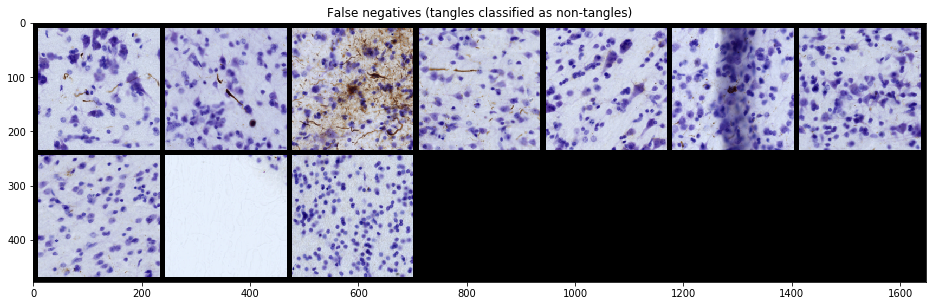

In [49]:
# Plot the false negatives
plt.figure(figsize=(16,16))
show(torchvision.utils.make_grid(img_fn, padding=10, nrow=7, normalize=True))
plt.title("False negatives (tangles classified as non-tangles)");
list(map(os.path.realpath, path_fn))

# OpenSlide loader

In [11]:
import openslide

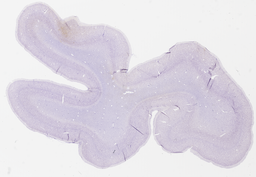

In [12]:
# Read a slide and show thumbnail
os=openslide.OpenSlide('/home/pyushkevich/285342.svs')
os.get_thumbnail((256,256))

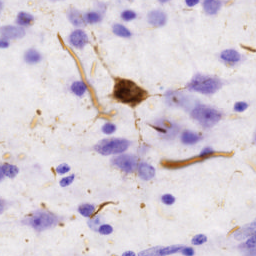

In [13]:
# Pull out a little region of the image
os.read_region((40350,20300),0,(256,256))

In [14]:
# A dataloader class based on the SVS
class OpenSlideTileDataset(torch.utils.data.Dataset):
    def __init__(self, svs_file, w_size, w_stride, transform=None):
        self.transform=transform
        self.os=openslide.OpenSlide(svs_file)
        self.w_size = w_size
        self.w_stride = w_stride
        
        self.n_win = (
            int((self.os.dimensions[0] - self.w_size[0]) / self.w_stride[0]),
            int((self.os.dimensions[1] - self.w_size[1]) / self.w_stride[1]))
            
    def __len__(self):
        return self.n_win[0] * self.n_win[1]
    
    def __getitem__(self, idx):
        i_y = int(idx / self.n_win[0])
        i_x = idx - i_y * self.n_win[0]
        offset = (i_x * self.w_stride[0], i_y * self.w_stride[1])
        img = os.read_region(offset, 0, self.w_size).convert("RGB")
        
        if self.transform:
            img = self.transform(img)
            
        return img,(i_x,i_y)
    
    def nwin(self):
        return self.n_win
        

In [15]:
osds=OpenSlideTileDataset('/home/pyushkevich/285342.svs', (400,400), (100,100), dt)
osdl = torch.utils.data.DataLoader(osds, batch_size=batch_size, shuffle=False, num_workers=1)

In [16]:
len(osdl)

58710

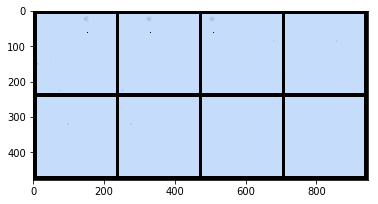

In [17]:
img,offs=next(iter(osdl))
show(torchvision.utils.make_grid(img, padding=10, nrow=4, normalize=True))

In [18]:
img_d = img.to(device)
outputs = model_ft(img_d)
_, preds = torch.max(outputs, 1)
preds

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [19]:
# Create arrays for storing output
p_nt=np.zeros(osds.nwin())
p_t=np.zeros(osds.nwin())
det_t=np.zeros(osds.nwin())

In [201]:
# Process entire slide (this will take forever)
n_tangles=0
n_tiles=0
for img,off in osdl:
    img_d = img.to(device)
    outputs = model_ft(img_d)
    _, preds = torch.max(outputs, 1)
    
    # Track number of detections
    n_tangles += sum(preds).item()
    n_tiles += len(preds)
    
    # Set the index
    for i in range(0,batch_size):
        off_i=(off[0][i].item(),off[1][i].item())
        p_nt[off_i] = outputs[i,0].item()
        p_t[off_i] = outputs[i,1].item()
        det_t[off_i] = preds[i].item()
        if preds[i].item() > 0:
            print("Tangle at ", off_i)
    
    if n_tiles % 200 == 0:
        print("Tiles/tangles: ",(n_tiles,n_tangles))

Tiles/tangles:  (200, 0)
Tiles/tangles:  (400, 0)
Tiles/tangles:  (600, 0)
Tiles/tangles:  (800, 0)
Tiles/tangles:  (1000, 0)
Tiles/tangles:  (1200, 0)
Tiles/tangles:  (1400, 0)
Tiles/tangles:  (1600, 0)
Tiles/tangles:  (1800, 0)
Tiles/tangles:  (2000, 0)
Tiles/tangles:  (2200, 0)
Tiles/tangles:  (2400, 0)
Tiles/tangles:  (2600, 0)
Tiles/tangles:  (2800, 0)
Tiles/tangles:  (3000, 0)
Tiles/tangles:  (3200, 0)
Tiles/tangles:  (3400, 0)
Tiles/tangles:  (3600, 0)
Tiles/tangles:  (3800, 0)
Tiles/tangles:  (4000, 0)
Tiles/tangles:  (4200, 0)
Tiles/tangles:  (4400, 0)
Tiles/tangles:  (4600, 0)
Tiles/tangles:  (4800, 0)
Tiles/tangles:  (5000, 0)
Tiles/tangles:  (5200, 0)
Tiles/tangles:  (5400, 0)
Tiles/tangles:  (5600, 0)
Tiles/tangles:  (5800, 0)
Tiles/tangles:  (6000, 0)
Tiles/tangles:  (6200, 0)
Tiles/tangles:  (6400, 0)
Tiles/tangles:  (6600, 0)
Tiles/tangles:  (6800, 0)
Tiles/tangles:  (7000, 0)
Tiles/tangles:  (7200, 0)
Tiles/tangles:  (7400, 0)
Tiles/tangles:  (7600, 0)
Tiles/tangles:  

Tiles/tangles:  (27400, 221)
Tiles/tangles:  (27600, 221)
Tiles/tangles:  (27800, 221)
Tiles/tangles:  (28000, 221)
Tangle at  (84, 34)
Tangle at  (85, 34)
Tangle at  (86, 34)
Tangle at  (87, 34)
Tangle at  (158, 34)
Tangle at  (159, 34)
Tangle at  (165, 34)
Tangle at  (166, 34)
Tangle at  (167, 34)
Tangle at  (168, 34)
Tangle at  (169, 34)
Tangle at  (170, 34)
Tiles/tangles:  (28200, 233)
Tiles/tangles:  (28400, 233)
Tiles/tangles:  (28600, 233)
Tiles/tangles:  (28800, 233)
Tangle at  (76, 35)
Tangle at  (77, 35)
Tangle at  (78, 35)
Tangle at  (85, 35)
Tangle at  (86, 35)
Tangle at  (153, 35)
Tangle at  (154, 35)
Tangle at  (155, 35)
Tangle at  (156, 35)
Tangle at  (157, 35)
Tangle at  (158, 35)
Tangle at  (159, 35)
Tiles/tangles:  (29000, 245)
Tangle at  (160, 35)
Tangle at  (161, 35)
Tangle at  (162, 35)
Tangle at  (163, 35)
Tangle at  (164, 35)
Tangle at  (165, 35)
Tangle at  (167, 35)
Tangle at  (168, 35)
Tangle at  (169, 35)
Tiles/tangles:  (29200, 254)
Tiles/tangles:  (29400, 25

Tiles/tangles:  (49000, 474)
Tiles/tangles:  (49200, 474)
Tiles/tangles:  (49400, 474)
Tiles/tangles:  (49600, 474)
Tangle at  (174, 60)
Tangle at  (175, 60)
Tangle at  (176, 60)
Tangle at  (177, 60)
Tangle at  (178, 60)
Tangle at  (179, 60)
Tangle at  (180, 60)
Tangle at  (181, 60)
Tangle at  (182, 60)
Tangle at  (183, 60)
Tangle at  (184, 60)
Tangle at  (185, 60)
Tangle at  (186, 60)
Tiles/tangles:  (49800, 487)
Tiles/tangles:  (50000, 487)
Tiles/tangles:  (50200, 487)
Tangle at  (77, 61)
Tangle at  (78, 61)
Tangle at  (79, 61)
Tiles/tangles:  (50400, 490)
Tangle at  (158, 61)
Tangle at  (174, 61)
Tangle at  (175, 61)
Tangle at  (176, 61)
Tangle at  (177, 61)
Tangle at  (178, 61)
Tangle at  (179, 61)
Tangle at  (180, 61)
Tangle at  (181, 61)
Tangle at  (182, 61)
Tangle at  (183, 61)
Tangle at  (184, 61)
Tangle at  (185, 61)
Tangle at  (186, 61)
Tangle at  (231, 61)
Tangle at  (232, 61)
Tangle at  (233, 61)
Tiles/tangles:  (50600, 507)
Tiles/tangles:  (50800, 507)
Tiles/tangles:  (510

Tangle at  (224, 73)
Tangle at  (225, 73)
Tangle at  (226, 73)
Tangle at  (227, 73)
Tiles/tangles:  (60400, 801)
Tiles/tangles:  (60600, 801)
Tiles/tangles:  (60800, 801)
Tiles/tangles:  (61000, 801)
Tangle at  (65, 74)
Tangle at  (98, 74)
Tangle at  (99, 74)
Tangle at  (168, 74)
Tangle at  (169, 74)
Tangle at  (170, 74)
Tangle at  (183, 74)
Tangle at  (184, 74)
Tangle at  (185, 74)
Tangle at  (186, 74)
Tangle at  (187, 74)
Tangle at  (188, 74)
Tangle at  (189, 74)
Tangle at  (190, 74)
Tangle at  (191, 74)
Tangle at  (192, 74)
Tangle at  (194, 74)
Tangle at  (195, 74)
Tangle at  (196, 74)
Tangle at  (197, 74)
Tangle at  (198, 74)
Tangle at  (208, 74)
Tangle at  (209, 74)
Tangle at  (210, 74)
Tiles/tangles:  (61200, 825)
Tangle at  (224, 74)
Tangle at  (225, 74)
Tangle at  (226, 74)
Tangle at  (227, 74)
Tiles/tangles:  (61400, 829)
Tiles/tangles:  (61600, 829)
Tiles/tangles:  (61800, 829)
Tangle at  (63, 75)
Tangle at  (64, 75)
Tangle at  (65, 75)
Tangle at  (66, 75)
Tangle at  (168, 75

Tangle at  (209, 82)
Tangle at  (210, 82)
Tangle at  (211, 82)
Tangle at  (212, 82)
Tangle at  (213, 82)
Tangle at  (214, 82)
Tangle at  (215, 82)
Tangle at  (216, 82)
Tangle at  (217, 82)
Tangle at  (218, 82)
Tangle at  (225, 82)
Tiles/tangles:  (67800, 1159)
Tangle at  (232, 82)
Tangle at  (233, 82)
Tangle at  (234, 82)
Tangle at  (235, 82)
Tangle at  (236, 82)
Tangle at  (237, 82)
Tangle at  (243, 82)
Tangle at  (248, 82)
Tangle at  (249, 82)
Tangle at  (250, 82)
Tangle at  (251, 82)
Tiles/tangles:  (68000, 1170)
Tiles/tangles:  (68200, 1170)
Tiles/tangles:  (68400, 1170)
Tangle at  (185, 83)
Tangle at  (186, 83)
Tangle at  (187, 83)
Tangle at  (188, 83)
Tangle at  (189, 83)
Tangle at  (190, 83)
Tangle at  (191, 83)
Tangle at  (192, 83)
Tangle at  (193, 83)
Tangle at  (195, 83)
Tangle at  (196, 83)
Tangle at  (197, 83)
Tangle at  (198, 83)
Tangle at  (207, 83)
Tiles/tangles:  (68600, 1184)
Tangle at  (208, 83)
Tangle at  (209, 83)
Tangle at  (210, 83)
Tangle at  (211, 83)
Tangle at 

Tiles/tangles:  (73000, 1508)
Tiles/tangles:  (73200, 1508)
Tangle at  (59, 89)
Tiles/tangles:  (73400, 1509)
Tangle at  (171, 89)
Tangle at  (172, 89)
Tangle at  (173, 89)
Tangle at  (174, 89)
Tangle at  (189, 89)
Tangle at  (190, 89)
Tangle at  (191, 89)
Tangle at  (192, 89)
Tangle at  (193, 89)
Tangle at  (194, 89)
Tangle at  (195, 89)
Tangle at  (196, 89)
Tangle at  (197, 89)
Tangle at  (198, 89)
Tangle at  (201, 89)
Tangle at  (202, 89)
Tangle at  (203, 89)
Tangle at  (204, 89)
Tangle at  (205, 89)
Tangle at  (206, 89)
Tangle at  (207, 89)
Tangle at  (208, 89)
Tangle at  (209, 89)
Tangle at  (210, 89)
Tangle at  (211, 89)
Tangle at  (212, 89)
Tangle at  (215, 89)
Tangle at  (216, 89)
Tangle at  (217, 89)
Tangle at  (218, 89)
Tangle at  (219, 89)
Tangle at  (220, 89)
Tangle at  (221, 89)
Tangle at  (222, 89)
Tangle at  (223, 89)
Tangle at  (224, 89)
Tangle at  (225, 89)
Tangle at  (226, 89)
Tangle at  (227, 89)
Tangle at  (241, 89)
Tangle at  (242, 89)
Tangle at  (243, 89)
Tangle a

Tangle at  (216, 94)
Tangle at  (217, 94)
Tangle at  (218, 94)
Tangle at  (219, 94)
Tangle at  (221, 94)
Tangle at  (222, 94)
Tangle at  (223, 94)
Tangle at  (224, 94)
Tangle at  (225, 94)
Tangle at  (226, 94)
Tangle at  (227, 94)
Tangle at  (228, 94)
Tangle at  (229, 94)
Tangle at  (230, 94)
Tangle at  (231, 94)
Tangle at  (232, 94)
Tangle at  (233, 94)
Tangle at  (237, 94)
Tangle at  (238, 94)
Tangle at  (239, 94)
Tangle at  (240, 94)
Tangle at  (241, 94)
Tangle at  (242, 94)
Tangle at  (243, 94)
Tangle at  (244, 94)
Tangle at  (245, 94)
Tangle at  (247, 94)
Tangle at  (248, 94)
Tangle at  (249, 94)
Tangle at  (254, 94)
Tangle at  (255, 94)
Tangle at  (256, 94)
Tangle at  (257, 94)
Tangle at  (258, 94)
Tangle at  (265, 94)
Tangle at  (266, 94)
Tangle at  (267, 94)
Tangle at  (268, 94)
Tangle at  (269, 94)
Tangle at  (270, 94)
Tangle at  (271, 94)
Tangle at  (286, 94)
Tangle at  (287, 94)
Tangle at  (288, 94)
Tangle at  (289, 94)
Tangle at  (303, 94)
Tangle at  (304, 94)
Tangle at  (3

Tiles/tangles:  (81200, 2250)
Tiles/tangles:  (81400, 2250)
Tiles/tangles:  (81600, 2250)
Tangle at  (180, 99)
Tangle at  (181, 99)
Tangle at  (182, 99)
Tangle at  (183, 99)
Tangle at  (188, 99)
Tangle at  (189, 99)
Tangle at  (190, 99)
Tangle at  (191, 99)
Tangle at  (195, 99)
Tangle at  (196, 99)
Tangle at  (197, 99)
Tangle at  (198, 99)
Tangle at  (200, 99)
Tangle at  (201, 99)
Tangle at  (202, 99)
Tangle at  (203, 99)
Tangle at  (204, 99)
Tangle at  (206, 99)
Tangle at  (207, 99)
Tangle at  (208, 99)
Tangle at  (209, 99)
Tangle at  (210, 99)
Tangle at  (211, 99)
Tangle at  (212, 99)
Tangle at  (213, 99)
Tangle at  (214, 99)
Tangle at  (220, 99)
Tangle at  (221, 99)
Tangle at  (222, 99)
Tangle at  (223, 99)
Tiles/tangles:  (81800, 2280)
Tangle at  (224, 99)
Tangle at  (225, 99)
Tangle at  (236, 99)
Tangle at  (237, 99)
Tangle at  (246, 99)
Tangle at  (247, 99)
Tangle at  (248, 99)
Tangle at  (250, 99)
Tangle at  (251, 99)
Tangle at  (252, 99)
Tangle at  (253, 99)
Tangle at  (257, 99

Tiles/tangles:  (86600, 2589)
Tangle at  (172, 105)
Tangle at  (173, 105)
Tangle at  (174, 105)
Tangle at  (175, 105)
Tangle at  (193, 105)
Tangle at  (194, 105)
Tangle at  (195, 105)
Tangle at  (196, 105)
Tangle at  (197, 105)
Tangle at  (198, 105)
Tangle at  (199, 105)
Tangle at  (202, 105)
Tangle at  (203, 105)
Tangle at  (204, 105)
Tangle at  (206, 105)
Tangle at  (207, 105)
Tangle at  (215, 105)
Tangle at  (216, 105)
Tangle at  (217, 105)
Tangle at  (218, 105)
Tangle at  (220, 105)
Tangle at  (222, 105)
Tangle at  (223, 105)
Tangle at  (224, 105)
Tangle at  (225, 105)
Tangle at  (226, 105)
Tangle at  (229, 105)
Tangle at  (236, 105)
Tangle at  (237, 105)
Tangle at  (238, 105)
Tangle at  (239, 105)
Tangle at  (240, 105)
Tangle at  (244, 105)
Tangle at  (245, 105)
Tangle at  (246, 105)
Tangle at  (247, 105)
Tangle at  (248, 105)
Tangle at  (249, 105)
Tangle at  (250, 105)
Tangle at  (251, 105)
Tangle at  (253, 105)
Tangle at  (254, 105)
Tangle at  (264, 105)
Tangle at  (265, 105)
Ta

Tangle at  (264, 111)
Tangle at  (275, 111)
Tangle at  (276, 111)
Tangle at  (277, 111)
Tangle at  (278, 111)
Tangle at  (301, 111)
Tangle at  (302, 111)
Tiles/tangles:  (91800, 2939)
Tangle at  (384, 111)
Tangle at  (385, 111)
Tangle at  (386, 111)
Tangle at  (387, 111)
Tiles/tangles:  (92000, 2943)
Tiles/tangles:  (92200, 2943)
Tiles/tangles:  (92400, 2943)
Tangle at  (190, 112)
Tangle at  (191, 112)
Tangle at  (192, 112)
Tangle at  (193, 112)
Tangle at  (194, 112)
Tangle at  (195, 112)
Tangle at  (196, 112)
Tangle at  (197, 112)
Tangle at  (207, 112)
Tangle at  (208, 112)
Tangle at  (209, 112)
Tangle at  (211, 112)
Tangle at  (212, 112)
Tangle at  (213, 112)
Tangle at  (214, 112)
Tangle at  (215, 112)
Tangle at  (216, 112)
Tangle at  (217, 112)
Tangle at  (218, 112)
Tangle at  (219, 112)
Tangle at  (220, 112)
Tangle at  (221, 112)
Tangle at  (226, 112)
Tangle at  (227, 112)
Tangle at  (232, 112)
Tangle at  (233, 112)
Tangle at  (234, 112)
Tangle at  (238, 112)
Tangle at  (239, 112)


Tangle at  (226, 121)
Tangle at  (227, 121)
Tangle at  (228, 121)
Tangle at  (229, 121)
Tangle at  (230, 121)
Tangle at  (231, 121)
Tangle at  (232, 121)
Tangle at  (233, 121)
Tangle at  (234, 121)
Tangle at  (235, 121)
Tangle at  (236, 121)
Tangle at  (280, 121)
Tangle at  (281, 121)
Tangle at  (282, 121)
Tangle at  (283, 121)
Tangle at  (284, 121)
Tiles/tangles:  (100000, 3265)
Tangle at  (346, 121)
Tangle at  (347, 121)
Tangle at  (348, 121)
Tangle at  (349, 121)
Tiles/tangles:  (100200, 3269)
Tiles/tangles:  (100400, 3269)
Tiles/tangles:  (100600, 3269)
Tangle at  (113, 122)
Tangle at  (200, 122)
Tangle at  (201, 122)
Tangle at  (204, 122)
Tangle at  (205, 122)
Tangle at  (206, 122)
Tangle at  (207, 122)
Tangle at  (208, 122)
Tangle at  (209, 122)
Tangle at  (214, 122)
Tangle at  (215, 122)
Tangle at  (216, 122)
Tangle at  (226, 122)
Tangle at  (227, 122)
Tangle at  (228, 122)
Tangle at  (229, 122)
Tangle at  (230, 122)
Tangle at  (231, 122)
Tangle at  (233, 122)
Tangle at  (234, 1

Tangle at  (224, 131)
Tangle at  (226, 131)
Tangle at  (227, 131)
Tangle at  (228, 131)
Tangle at  (239, 131)
Tangle at  (240, 131)
Tangle at  (241, 131)
Tangle at  (242, 131)
Tiles/tangles:  (108200, 3574)
Tangle at  (365, 131)
Tangle at  (366, 131)
Tiles/tangles:  (108400, 3576)
Tiles/tangles:  (108600, 3576)
Tiles/tangles:  (108800, 3576)
Tangle at  (94, 132)
Tangle at  (100, 132)
Tangle at  (109, 132)
Tangle at  (116, 132)
Tangle at  (210, 132)
Tangle at  (211, 132)
Tangle at  (212, 132)
Tangle at  (213, 132)
Tangle at  (214, 132)
Tangle at  (215, 132)
Tangle at  (216, 132)
Tangle at  (217, 132)
Tangle at  (226, 132)
Tangle at  (227, 132)
Tangle at  (228, 132)
Tangle at  (229, 132)
Tiles/tangles:  (109000, 3592)
Tangle at  (233, 132)
Tangle at  (239, 132)
Tangle at  (240, 132)
Tangle at  (241, 132)
Tangle at  (242, 132)
Tangle at  (252, 132)
Tangle at  (253, 132)
Tangle at  (254, 132)
Tangle at  (255, 132)
Tangle at  (365, 132)
Tangle at  (366, 132)
Tiles/tangles:  (109200, 3603)
T

Tangle at  (599, 149)
Tangle at  (600, 149)
Tangle at  (601, 149)
Tangle at  (602, 149)
Tiles/tangles:  (123400, 3841)
Tiles/tangles:  (123600, 3841)
Tangle at  (79, 150)
Tangle at  (82, 150)
Tangle at  (83, 150)
Tangle at  (84, 150)
Tiles/tangles:  (123800, 3845)
Tangle at  (369, 150)
Tangle at  (370, 150)
Tangle at  (371, 150)
Tangle at  (372, 150)
Tiles/tangles:  (124000, 3849)
Tangle at  (405, 150)
Tangle at  (406, 150)
Tangle at  (598, 150)
Tangle at  (599, 150)
Tiles/tangles:  (124200, 3853)
Tangle at  (600, 150)
Tangle at  (601, 150)
Tangle at  (602, 150)
Tiles/tangles:  (124400, 3856)
Tangle at  (79, 151)
Tangle at  (80, 151)
Tangle at  (81, 151)
Tangle at  (82, 151)
Tangle at  (83, 151)
Tangle at  (84, 151)
Tangle at  (85, 151)
Tiles/tangles:  (124600, 3863)
Tangle at  (370, 151)
Tangle at  (371, 151)
Tangle at  (372, 151)
Tiles/tangles:  (124800, 3866)
Tiles/tangles:  (125000, 3866)
Tangle at  (598, 151)
Tangle at  (599, 151)
Tangle at  (600, 151)
Tangle at  (601, 151)
Tangle

Tiles/tangles:  (137400, 4120)
Tangle at  (622, 166)
Tangle at  (623, 166)
Tangle at  (624, 166)
Tangle at  (625, 166)
Tangle at  (637, 166)
Tangle at  (638, 166)
Tangle at  (639, 166)
Tangle at  (640, 166)
Tangle at  (658, 166)
Tangle at  (659, 166)
Tangle at  (664, 166)
Tiles/tangles:  (137600, 4131)
Tiles/tangles:  (137800, 4131)
Tangle at  (374, 167)
Tangle at  (375, 167)
Tangle at  (376, 167)
Tangle at  (377, 167)
Tiles/tangles:  (138000, 4135)
Tangle at  (396, 167)
Tangle at  (397, 167)
Tangle at  (398, 167)
Tangle at  (408, 167)
Tangle at  (409, 167)
Tangle at  (410, 167)
Tangle at  (411, 167)
Tiles/tangles:  (138200, 4142)
Tangle at  (622, 167)
Tangle at  (623, 167)
Tangle at  (624, 167)
Tangle at  (625, 167)
Tangle at  (637, 167)
Tangle at  (638, 167)
Tangle at  (639, 167)
Tangle at  (640, 167)
Tangle at  (657, 167)
Tangle at  (658, 167)
Tangle at  (659, 167)
Tangle at  (660, 167)
Tiles/tangles:  (138400, 4154)
Tiles/tangles:  (138600, 4154)
Tiles/tangles:  (138800, 4154)
Tang

Tiles/tangles:  (148800, 4414)
Tangle at  (668, 180)
Tangle at  (669, 180)
Tangle at  (670, 180)
Tangle at  (671, 180)
Tiles/tangles:  (149000, 4418)
Tiles/tangles:  (149200, 4418)
Tiles/tangles:  (149400, 4418)
Tangle at  (413, 181)
Tangle at  (414, 181)
Tangle at  (415, 181)
Tangle at  (416, 181)
Tiles/tangles:  (149600, 4422)
Tangle at  (536, 181)
Tiles/tangles:  (149800, 4423)
Tangle at  (667, 181)
Tangle at  (668, 181)
Tangle at  (669, 181)
Tiles/tangles:  (150000, 4426)
Tiles/tangles:  (150200, 4426)
Tangle at  (415, 182)
Tiles/tangles:  (150400, 4427)
Tangle at  (535, 182)
Tangle at  (536, 182)
Tangle at  (537, 182)
Tangle at  (538, 182)
Tiles/tangles:  (150600, 4431)
Tangle at  (653, 182)
Tangle at  (667, 182)
Tangle at  (668, 182)
Tangle at  (669, 182)
Tangle at  (685, 182)
Tangle at  (686, 182)
Tangle at  (687, 182)
Tangle at  (688, 182)
Tiles/tangles:  (150800, 4439)
Tiles/tangles:  (151000, 4439)
Tangle at  (264, 183)
Tangle at  (265, 183)
Tiles/tangles:  (151200, 4441)
Tan

Tiles/tangles:  (164200, 4679)
Tiles/tangles:  (164400, 4679)
Tangle at  (489, 199)
Tangle at  (490, 199)
Tangle at  (491, 199)
Tiles/tangles:  (164600, 4682)
Tangle at  (668, 199)
Tangle at  (692, 199)
Tangle at  (702, 199)
Tiles/tangles:  (164800, 4685)
Tiles/tangles:  (165000, 4685)
Tiles/tangles:  (165200, 4685)
Tangle at  (403, 200)
Tangle at  (488, 200)
Tangle at  (489, 200)
Tangle at  (490, 200)
Tangle at  (491, 200)
Tangle at  (493, 200)
Tangle at  (494, 200)
Tangle at  (495, 200)
Tangle at  (496, 200)
Tiles/tangles:  (165400, 4694)
Tangle at  (648, 200)
Tangle at  (675, 200)
Tangle at  (692, 200)
Tangle at  (693, 200)
Tangle at  (702, 200)
Tiles/tangles:  (165600, 4699)
Tiles/tangles:  (165800, 4699)
Tiles/tangles:  (166000, 4699)
Tangle at  (401, 201)
Tangle at  (402, 201)
Tangle at  (403, 201)
Tangle at  (404, 201)
Tangle at  (488, 201)
Tangle at  (489, 201)
Tangle at  (490, 201)
Tangle at  (491, 201)
Tangle at  (493, 201)
Tangle at  (494, 201)
Tangle at  (495, 201)
Tangle a

Tangle at  (709, 217)
Tangle at  (710, 217)
Tiles/tangles:  (179600, 4946)
Tiles/tangles:  (179800, 4946)
Tangle at  (184, 218)
Tangle at  (185, 218)
Tangle at  (186, 218)
Tangle at  (187, 218)
Tiles/tangles:  (180000, 4950)
Tangle at  (403, 218)
Tangle at  (468, 218)
Tangle at  (469, 218)
Tangle at  (470, 218)
Tangle at  (507, 218)
Tangle at  (508, 218)
Tangle at  (509, 218)
Tangle at  (518, 218)
Tangle at  (519, 218)
Tangle at  (520, 218)
Tangle at  (521, 218)
Tiles/tangles:  (180200, 4961)
Tangle at  (674, 218)
Tangle at  (675, 218)
Tangle at  (676, 218)
Tangle at  (677, 218)
Tangle at  (705, 218)
Tiles/tangles:  (180400, 4966)
Tiles/tangles:  (180600, 4966)
Tangle at  (184, 219)
Tangle at  (185, 219)
Tangle at  (186, 219)
Tangle at  (187, 219)
Tangle at  (288, 219)
Tangle at  (289, 219)
Tiles/tangles:  (180800, 4972)
Tangle at  (395, 219)
Tangle at  (396, 219)
Tangle at  (397, 219)
Tangle at  (398, 219)
Tangle at  (403, 219)
Tangle at  (435, 219)
Tangle at  (468, 219)
Tangle at  (4

KeyboardInterrupt: 

In [20]:
(p_nt > 0).sum()

0

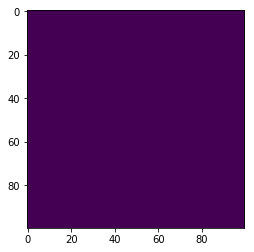

In [21]:
plt.imshow(p_nt[550:650,400:500])

In [22]:
p_nt[(20,20)]

0.0

In [23]:
preds[2].item()

0

In [24]:
# Try a better way of processing the slide
width=400
stride=100
chunk_dim=20
chunk_idx=(5,2)

# Read the chunk
chunk_img=os.read_region(
    (chunk_idx[0]*chunk_dim*stride,chunk_idx[1]*chunk_dim*stride), 0, (chunk_dim*stride,chunk_dim*stride)).convert("RGB")



chunk_tensor=chunk_dt(chunk_img).to(device)

# Split into batches


NameError: name 'chunk_dt' is not defined

In [ ]:
# Strides in pixels
stride=100

# Window size in strides
window_size=4

# Strides per chunk
chunk_size=40

# Determine the actual width of the image needed for this chunk
chunk_width=stride*(chunk_size+window_size-1)
print("Chunk width: ", chunk_width)

# Determine the dimensions of the output image
out_dim=(np.array(os.dimensions)/stride).astype(int)
out_pnt=np.zeros(out_dim)
out_ptg=np.zeros(out_dim)

# Transformed stride and width
stride_t = int(input_size / window_size)
chunk_width_t = int(stride_t*(chunk_size+window_size-1))

# Transform the chunk
chunk_dt = transforms.Compose([
        transforms.Resize(chunk_width_t),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Start at some position
u = 400; v = 200;

for u in range(0,int(out_dim[0]/chunk_size)*chunk_size,chunk_size):
    for v in range(0,int(out_dim[1]/chunk_size)*chunk_size,chunk_size):
#for u in range(360,480,chunk_size):
#    for v in range(280,400,chunk_size):

        # Read the chunk
        t0 = timeit.default_timer()
        chunk_img=os.read_region(
            (u*stride, v*stride), 0, (chunk_width,chunk_width)).convert("RGB")

        t1 = timeit.default_timer()
        
        chunk_tensor=chunk_dt(chunk_img).to(device)
        # print("Transformed chunk shape: ", chunk_tensor.shape)

        chunk_ufold=chunk_tensor.unfold(1,input_size,stride_t).unfold(2,input_size,stride_t).permute((1,2,0,3,4))
        # print("Unfolded chunk shape: ", chunk_ufold.shape)

        # Process batches
        t2 = timeit.default_timer()

        for i in range(0,chunk_size):
            y_i = model_ft(chunk_ufold[:,i,:,:,:]).cpu().detach().numpy()
            out_pnt[u+i,v:v+chunk_size] = y_i[:,0]
            out_ptg[u+i,v:v+chunk_size] = y_i[:,1]
            
        t3 = timeit.default_timer()
        
        # Report
        print("Completed chunk (%d,%d), t_read=%8.4f  t_ufld=%8.4f  t_cnn=%8.4f  t=%8.4f" %
              (u, v, t1-t0, t2-t1, t3-t2, t3-t0))

    

Chunk width:  4300
Completed chunk (0,0), t_read=  2.2759  t_ufld=  0.3445  t_cnn=  1.0386  t=  3.6589
Completed chunk (0,40), t_read=  1.0316  t_ufld=  0.3550  t_cnn=  1.0217  t=  2.4083
Completed chunk (0,80), t_read=  0.9141  t_ufld=  0.3482  t_cnn=  1.0216  t=  2.2839
Completed chunk (0,120), t_read=  0.8934  t_ufld=  0.3415  t_cnn=  1.0217  t=  2.2566
Completed chunk (0,160), t_read=  0.8980  t_ufld=  0.3419  t_cnn=  1.0213  t=  2.2612
Completed chunk (0,200), t_read=  0.9058  t_ufld=  0.3385  t_cnn=  1.0212  t=  2.2654
Completed chunk (0,240), t_read=  1.1069  t_ufld=  0.3386  t_cnn=  1.0211  t=  2.4666
Completed chunk (0,280), t_read=  1.7722  t_ufld=  0.3400  t_cnn=  1.0219  t=  3.1341
Completed chunk (0,320), t_read=  1.0917  t_ufld=  0.3427  t_cnn=  1.0215  t=  2.4559
Completed chunk (0,360), t_read=  1.0154  t_ufld=  0.3400  t_cnn=  1.0210  t=  2.3763
Completed chunk (0,400), t_read=  0.9810  t_ufld=  0.3234  t_cnn=  1.0210  t=  2.3254
Completed chunk (0,440), t_read=  1.198

Completed chunk (240,400), t_read=  2.0452  t_ufld=  0.3204  t_cnn=  1.0222  t=  3.3879
Completed chunk (240,440), t_read=  1.5971  t_ufld=  0.3208  t_cnn=  1.0226  t=  2.9405
Completed chunk (240,480), t_read=  1.6551  t_ufld=  0.3212  t_cnn=  1.0208  t=  2.9972
Completed chunk (240,520), t_read=  1.1268  t_ufld=  0.3222  t_cnn=  1.0223  t=  2.4714
Completed chunk (280,0), t_read=  2.1072  t_ufld=  0.3167  t_cnn=  1.0209  t=  3.4448
Completed chunk (280,40), t_read=  1.1762  t_ufld=  0.3213  t_cnn=  1.0205  t=  2.5180
Completed chunk (280,80), t_read=  1.9018  t_ufld=  0.3306  t_cnn=  1.0213  t=  3.2536
Completed chunk (280,120), t_read=  1.9212  t_ufld=  0.3222  t_cnn=  1.0215  t=  3.2649
Completed chunk (280,160), t_read=  1.7958  t_ufld=  0.3487  t_cnn=  1.0210  t=  3.1656
Completed chunk (280,200), t_read=  2.0874  t_ufld=  0.3290  t_cnn=  1.0223  t=  3.4386
Completed chunk (280,240), t_read=  1.6815  t_ufld=  0.3218  t_cnn=  1.0222  t=  3.0255
Completed chunk (280,280), t_read=  

Completed chunk (520,240), t_read=  1.7851  t_ufld=  0.3307  t_cnn=  1.0243  t=  3.1400
Completed chunk (520,280), t_read=  1.7611  t_ufld=  0.3875  t_cnn=  1.0235  t=  3.1721
Completed chunk (520,320), t_read=  1.7052  t_ufld=  0.3910  t_cnn=  1.0238  t=  3.1200
Completed chunk (520,360), t_read=  1.5923  t_ufld=  0.3654  t_cnn=  1.0209  t=  2.9787
Completed chunk (520,400), t_read=  1.7139  t_ufld=  0.3319  t_cnn=  1.0216  t=  3.0674
Completed chunk (520,440), t_read=  1.5056  t_ufld=  0.3462  t_cnn=  1.0221  t=  2.8739
Completed chunk (520,480), t_read=  1.5452  t_ufld=  0.3443  t_cnn=  1.0210  t=  2.9105
Completed chunk (520,520), t_read=  1.3992  t_ufld=  0.3429  t_cnn=  1.0224  t=  2.7646
Completed chunk (560,0), t_read=  2.2675  t_ufld=  0.3444  t_cnn=  1.0211  t=  3.6330
Completed chunk (560,40), t_read=  1.3048  t_ufld=  0.3454  t_cnn=  1.0217  t=  2.6719
Completed chunk (560,80), t_read=  1.1398  t_ufld=  0.3903  t_cnn=  1.0211  t=  2.5513
Completed chunk (560,120), t_read=  

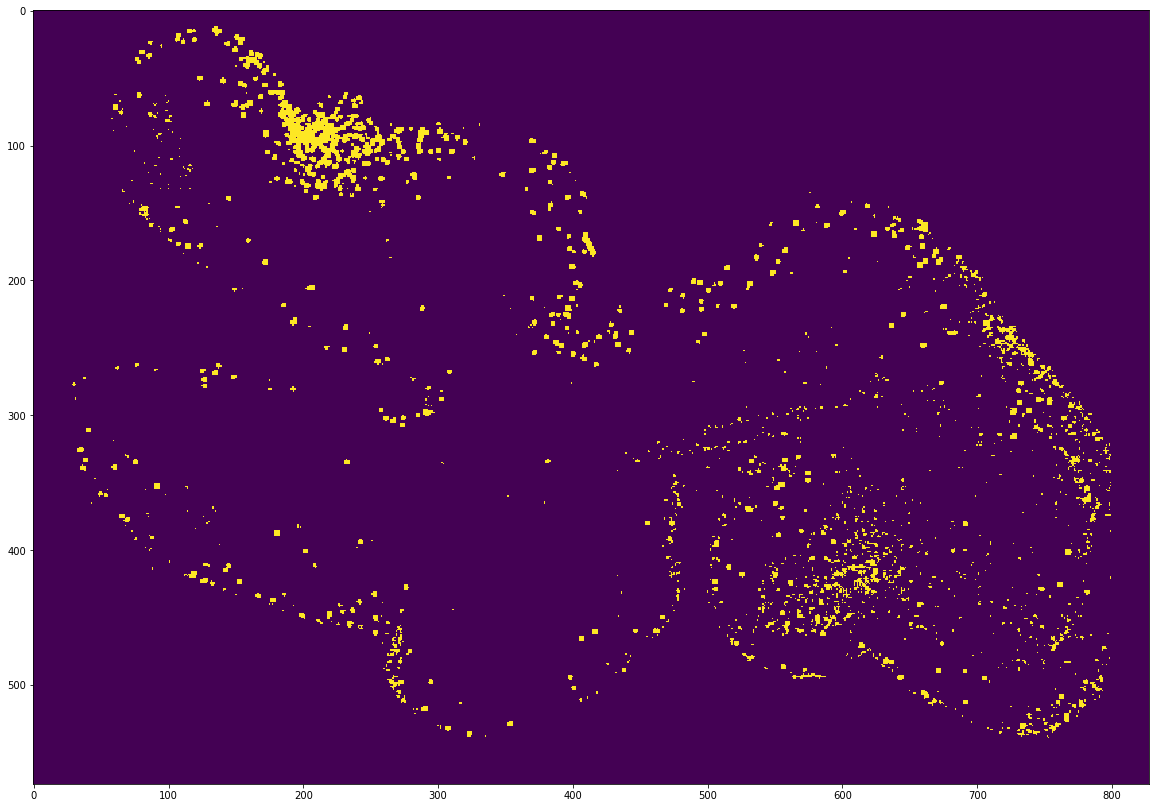

In [25]:
plt.figure(figsize=(20,20))
plt.imshow(out_ptg.transpose()>out_pnt.transpose())

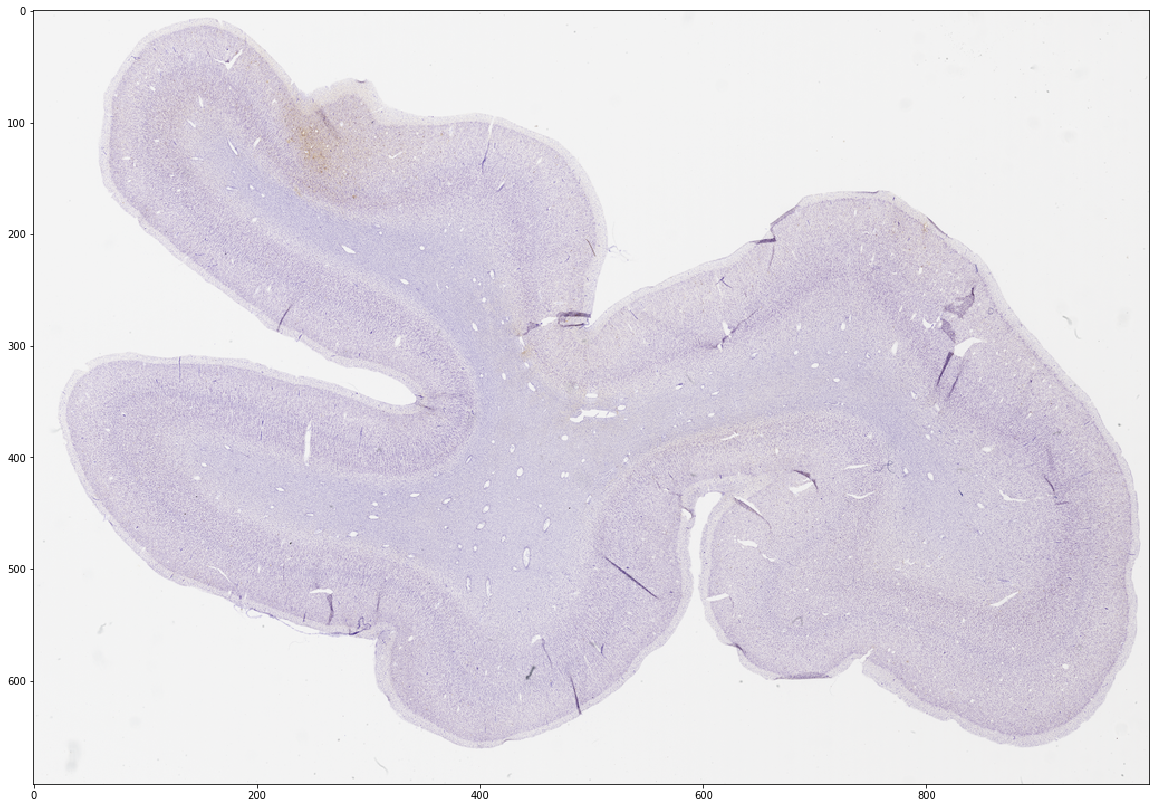

In [24]:
plt.figure(figsize=(20,20))
plt.imshow(os.get_thumbnail((1000,1000)))

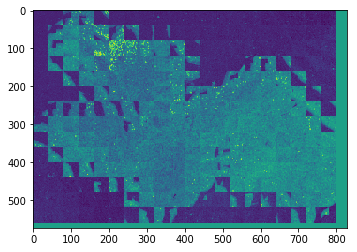

In [48]:
x=out_ptg
for u in range(0,int(out_dim[0]/chunk_size)*chunk_size,chunk_size):
    for v in range(0,int(out_dim[1]/chunk_size)*chunk_size,chunk_size):
        x[u:u+20,v:v+20]=np.fliplr(out_ptg[u:u+20,v:v+20].transpose())
plt.imshow(x.transpose())

In [61]:
x = torch.arange(0., 9)
x.unfold(0,4,1)

tensor([[0., 1., 2., 3.],
        [1., 2., 3., 4.],
        [2., 3., 4., 5.],
        [3., 4., 5., 6.],
        [4., 5., 6., 7.],
        [5., 6., 7., 8.]])

In [62]:
z=chunk_tensor.unfold(1,224,56).unfold(2,224,56).permute((0,3,4,1,2))

In [38]:
q=np.array([1,2,3,5])
q[1:-1:-1]

array([], dtype=int64)

In [64]:
z.reshape(3,224,224,-1).permute(3,0,1,2).size()

torch.Size([289, 3, 224, 224])

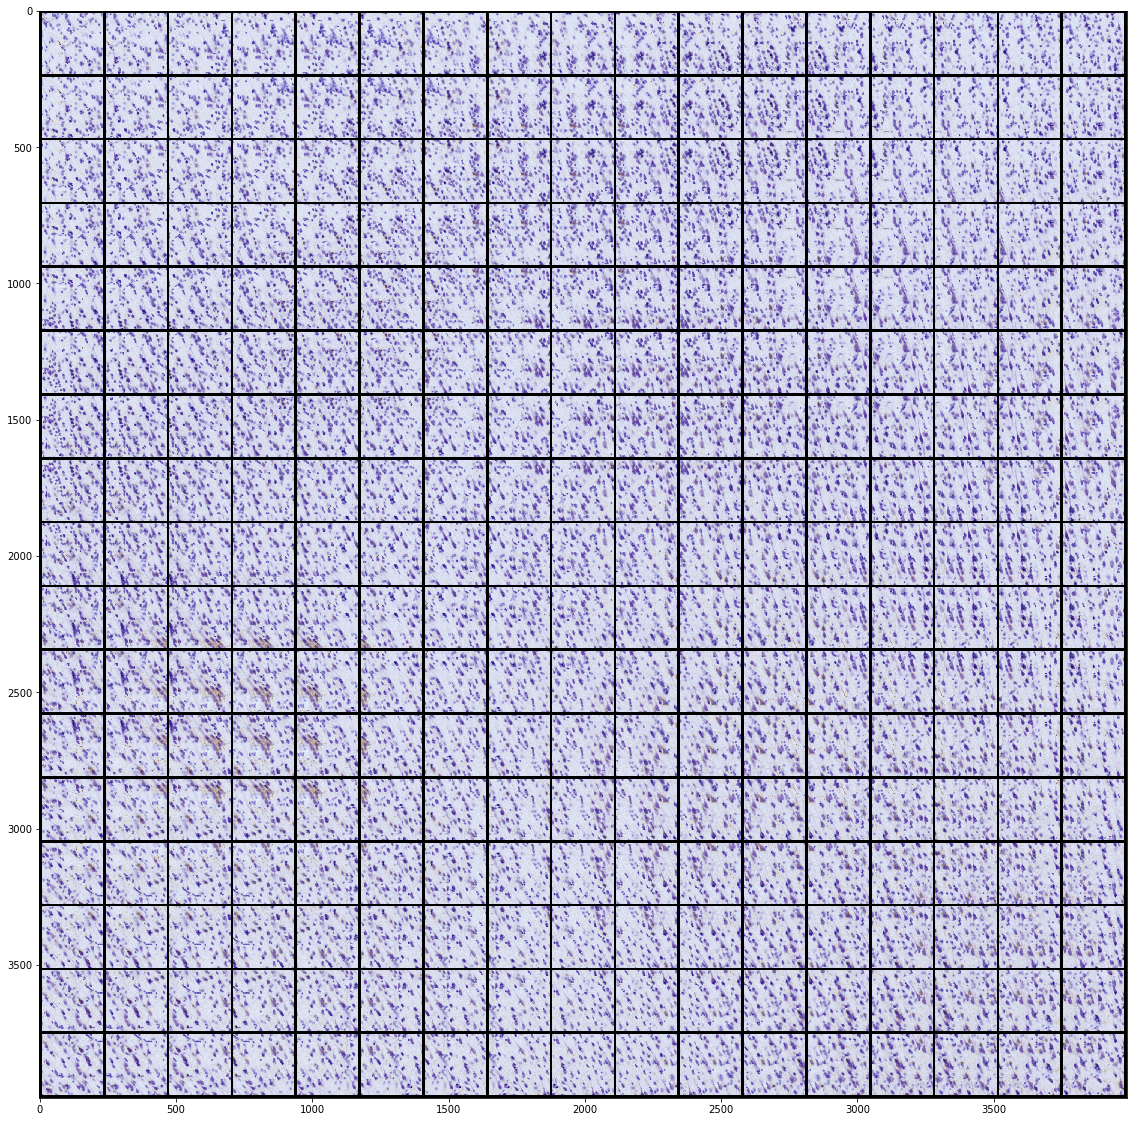

In [65]:
plt.figure(figsize=(20,20))
show(torchvision.utils.make_grid(z.reshape(3,224,224,-1).permute(3,0,1,2).cpu(), padding=10, nrow=17, normalize=True))

In [66]:
import timeit
t0=timeit.timeit()
out=model_ft(z.reshape(3,224,224,-1).permute(3,0,1,2))
t1=timeit.timeit()
print("Time elapsed: ", t1-t0)

Time elapsed:  -0.001879915002064081


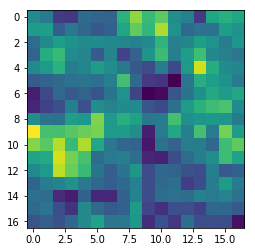

In [78]:
outt=out.reshape(17,17,2).permute(2,0,1)
plt.imshow(outt[0,:,:].detach().cpu())

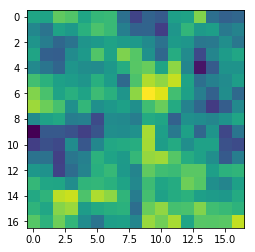

In [77]:
plt.imshow(outt[1,:,:].detach().cpu())